# Project: Lyft Competition

TBD

## Overview

TBD

## Key Research Questions

TBD

## Credits and Citations

* https://github.com/lyft/nuscenes-devkit
* https://www.kaggle.com/code/tarunpaparaju/lyft-competition-understanding-the-data
* https://www.kaggle.com/gaborfodor/eda-3d-object-detection-challenge

## 1. Introduction: TBD

TBD

## 1. Importing Libraries

In [1]:
# Installations
# Uncomment if running on Kaggle or Colab to install required packages

!pip install lyft_dataset_sdk

# The upgrades below are because of a scipy error. This works so do not touch.
!pip install --upgrade numpy==1.26.4
!pip install --upgrade scipy==1.14.1
!pip install --upgrade seaborn==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR:

In [2]:
# System & Utilities
import os
import glob
import gc
import numpy as np
import pandas as pd
from pandas import json_normalize
import sys
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
import seaborn as sns
from PIL import Image
import cv2

# Lfyt Dataset SDK
# The Lyft Level 5 Dataset was released publicly for research on autonomous driving, similar to the nuScenes dataset by Motional. 
# In fact, lyft_dataset_sdk is built upon a modified version of the nuScenes devkit, which means its APIs and data structures are nearly identical.
import lyft_dataset_sdk
from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

# sklearn
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix

# Misc
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import random
import json
import pickle
from datetime import datetime
import math
import time
from typing import Tuple, List, Dict
from pyquaternion import Quaternion
from tqdm import tqdm # Tqdm is a popular Python library designed to provide fast, extensible progress bars for loops and iterable tasks. 
import struct
from abc import ABC, abstractmethod
from functools import reduce
import copy

## 1.2 Version Checks

In [3]:
?lyft_dataset_sdk

Type:        module
String form: <module 'lyft_dataset_sdk' from '/usr/local/lib/python3.11/dist-packages/lyft_dataset_sdk/__init__.py'>
File:        /usr/local/lib/python3.11/dist-packages/lyft_dataset_sdk/__init__.py
Docstring:   <no docstring>


As per the official documentation on <a href="https://pypi.org/project/lyft-dataset-sdk/0.0.8/">Lyft Dataset SDK 0.0.08</a>, this is the latest version which was updated in 2019. However, as it is based on the Nuscenes SDK, and there are many proven notebooks on Kaggle that can help a newbie learn "Object Detection", this notebook will continue to use this module for academic and research purpose.

## 1.3 User Variables

In [4]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # print(dirname)

In [5]:
os.listdir('/kaggle/input') # The above code goes into a big loop as there are too many files in the subdirs

['3d-object-detection-for-autonomous-vehicles']

In [6]:
common_path = "/kaggle/input/3d-object-detection-for-autonomous-vehicles/"
train_datasets_path = common_path + 'train.csv'
sample_submission_path = common_path + 'sample_submission.csv'

In [7]:
output_dir = '/kaggle/working/outputs'
os.makedirs(output_dir, exist_ok=True)

# 2. Codes

The scope of this notebook is to first learn the basics. The organization and decoration of the codes will be done in the future :)

## 2.1 Exploring training data

In [8]:
df_train = pd.read_csv(train_datasets_path)
df_sample_submission = pd.read_csv(sample_submission_path)

In [9]:
df_train.columns

Index(['Id', 'PredictionString'], dtype='object')

In [10]:
df_sample_submission.columns

Index(['Id', 'PredictionString'], dtype='object')

In [11]:
df_train.head()

,Id,PredictionString
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...


In [12]:
df_sample_submission.head()

,Id,PredictionString
0,7eb3e546df5311b035f1d4b7e88351ffdd85f311ef1bdd...,NaN
1,a76d702996a086ecd4add92b6c533b76f0ab1dd35a4729...,NaN
2,a9919963e5cd83d12b60bb9c386869ecb4dffcf2e3c401...,NaN
3,e3f42dc16cb366723699a5e12098edb56907d676cb5720...,NaN
4,033edef20c7f951738c037c0275dc02279a15454fda3e6...,NaN


In [13]:
df_train["Id"][0]

'db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce76edd4af4d04e49341'

In [14]:
df_train["PredictionString"][0]

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778

In [15]:
df_train["PredictionString"][0].split()[:8]

['2680.2830359778527',
 '698.1969292852777',
 '-18.04776692365821',
 '2.064',
 '5.488',
 '2.053',
 '2.6041643845397946',
 'car']

In [16]:
df_train["PredictionString"][0].split()[8:16]

['2691.997461646401',
 '660.8016536569899',
 '-18.674258695658377',
 '1.818',
 '4.57',
 '1.608',
 '-0.33517602468486984',
 'car']

The annotation objects in the Lyft dataset's "PredictionString" are the 3D bounding boxes that represent various objects detected in the environment around the autonomous vehicle. Each annotated object describes a traffic agent or dynamic entity in the scene defined by the following fields in `train.csv`:

* `center_x`, `center_y` and `center_z` are the world coordinates of the center of the 3D bounding volume.
* `width`, `length` and `height` are the dimensions of the volume.
* `yaw` is the angle of the volume around the z axis (where y is forward/back, x is left/right, and z is up/down - making 'yaw' the direction the front of the vehicle / bounding box is pointing at while on the ground).
* `class_name` is the type of object contained by the bounding volume.

In [17]:
len(df_train["PredictionString"])

22680

In [18]:
number_of_annotated_objects = 8 # center_x, center_y, center_z, width, length, height, yaw, class_name

def count_objects(pred_string):
    if pd.isna(pred_string):
        return 0
    return len(pred_string.strip().split()) // number_of_annotated_objects

np.sum(df_train['PredictionString'].apply(count_objects))

638179

We have 638179 annotated objects in 22680 train samples.

In [19]:
def convert_df_actionable_insights(df_train):

    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    
    numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
    df_train_object_columns = numerical_cols + ['class_name']
    object_columns = ["sample_id"] + df_train_object_columns
    
    objects = []
    
    for sample_id, row in tqdm(df_train.values[:]):
        row_params = row.split()
        
        num_objects = len(row_params)
        number_of_annotated_objects = 8 # 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw', 'class_name'
        row_range = num_objects // number_of_annotated_objects
        
        for i in range(row_range):
            _start = i*8
            _end = (i+1)*8
            center_x, center_y, center_z, width, length, height, yaw, class_name = tuple(row_params[_start: _end])
    
            objects.append([sample_id, i, center_x, center_y, center_z, width, length, height, yaw, class_name])

    df_train_objects = pd.DataFrame(objects, columns = object_columns)

    # Convert string type to float32 for numerical columns
    df_train_objects[numerical_cols] = np.float32(df_train_objects[numerical_cols].values)

    return df_train_objects

In [20]:
df_train_objects = convert_df_actionable_insights(df_train)
df_train_objects.head(2)

100%|██████████| 22680/22680 [00:01<00:00, 11662.03it/s]


,sample_id,object_id,center_x,center_y,center_z,width,length,height,yaw,class_name
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,0.0,2680.282959,698.196899,-18.047768,2.064,5.488,2.053,2.604164,car
1,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,1.0,2691.997559,660.801636,-18.674259,1.818,4.570,1.608,-0.335176,car


We now have the training data with the appropriate columns and splits

## 2.2 EDA

### 2.2.1 Distributions of `center_x` and `center_y`

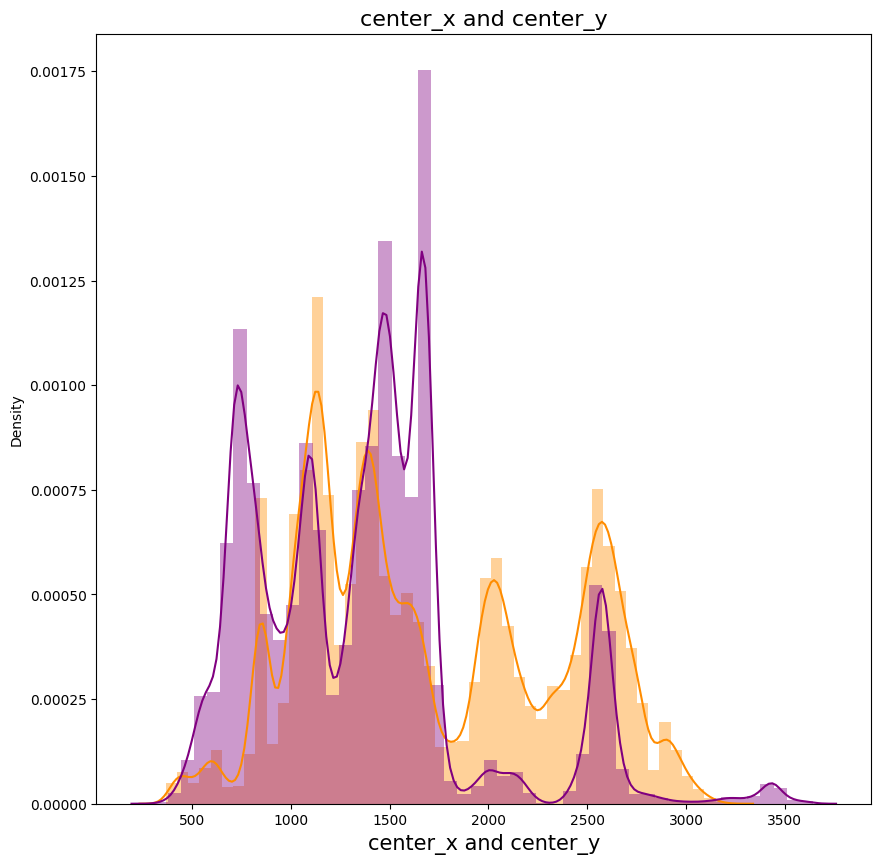

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df_train_objects['center_x'], color='darkorange', ax=ax).set_title('center_x and center_y', fontsize=16)
sns.distplot(df_train_objects['center_y'], color='purple', ax=ax).set_title('center_x and center_y', fontsize=16)
plt.xlabel('center_x and center_y', fontsize=15)
plt.show()

### 2.2.2 KDE Distribution

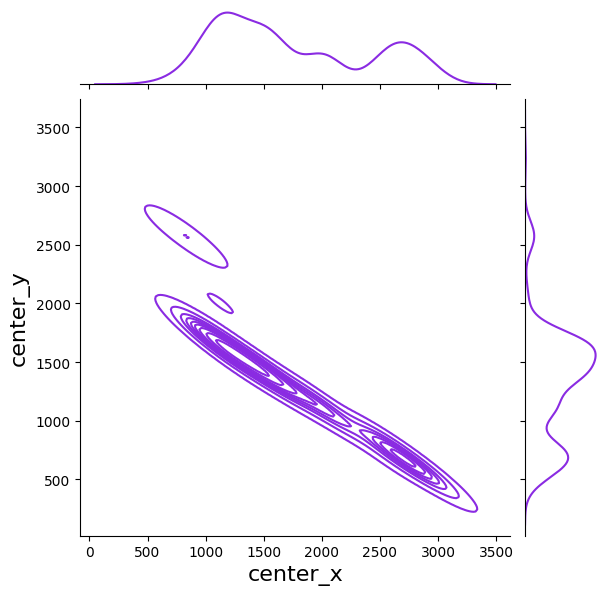

In [24]:
df_new_train_objects = df_train_objects.query('class_name == "car"')
plot = sns.jointplot(x=df_new_train_objects['center_x'][:1000], y=df_new_train_objects['center_y'][:1000], 
                     kind='kde', color='blueviolet')
plot.set_axis_labels('center_x', 'center_y', fontsize=16)
plt.show()

### 2.2.3 Distribution of `center-z`

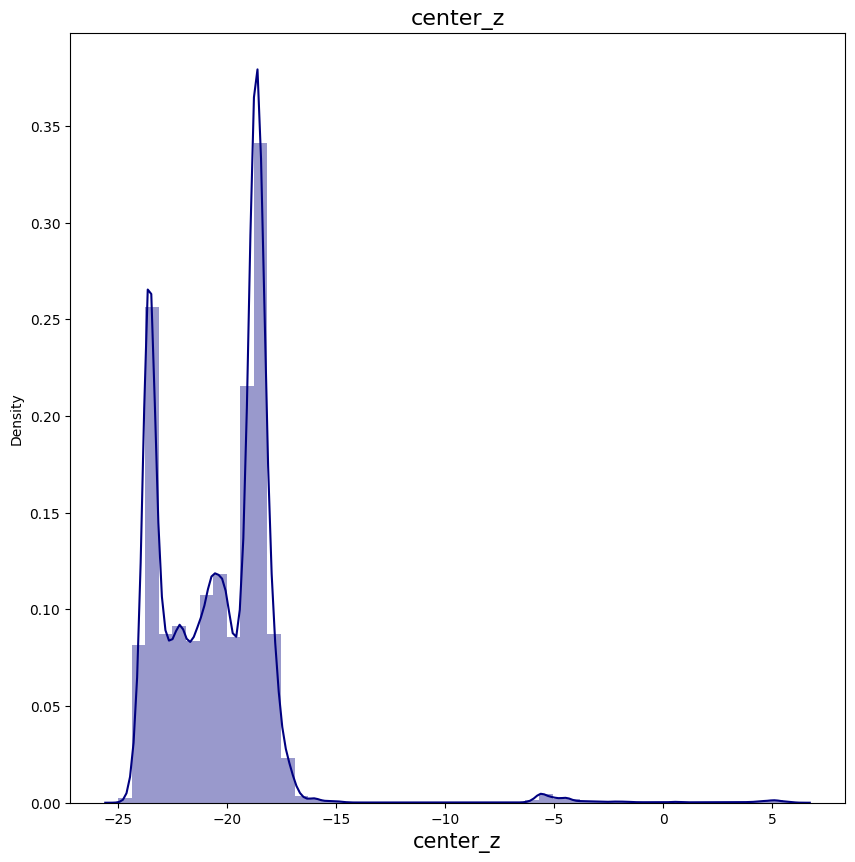

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df_train_objects['center_z'], color='navy', ax=ax).set_title('center_z', fontsize=16)
plt.xlabel('center_z', fontsize=15)
plt.show()

### 2.2.4 Distribution of `yaw`

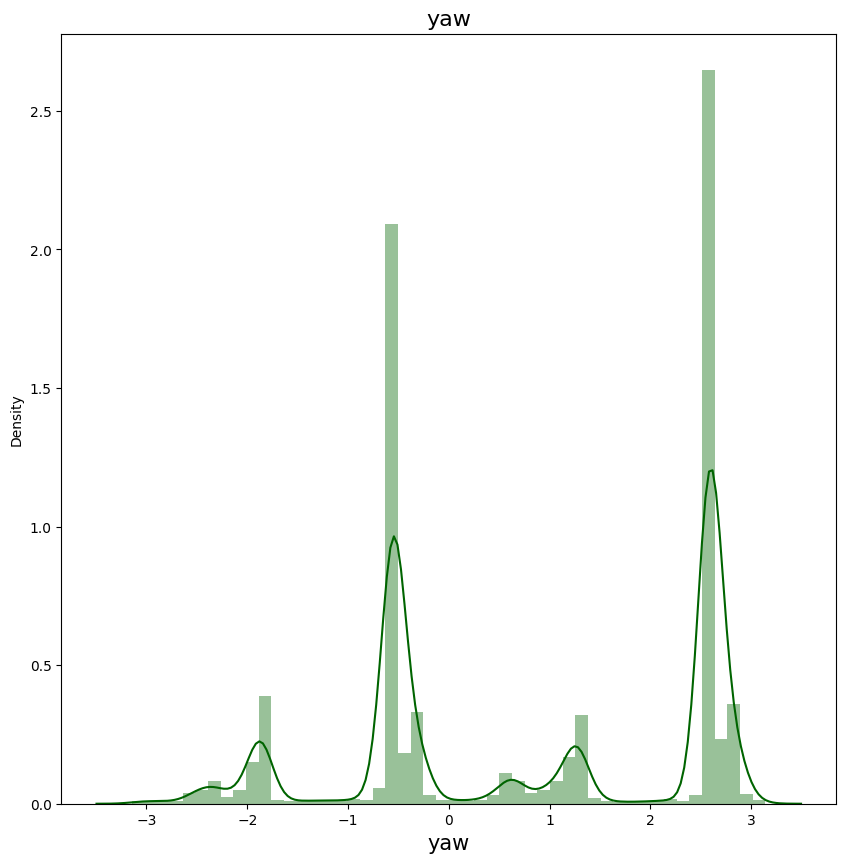

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df_train_objects['yaw'], color='darkgreen', ax=ax).set_title('yaw', fontsize=16)
plt.xlabel('yaw', fontsize=15)
plt.show()

### 2.2.5 Distribution of `width`

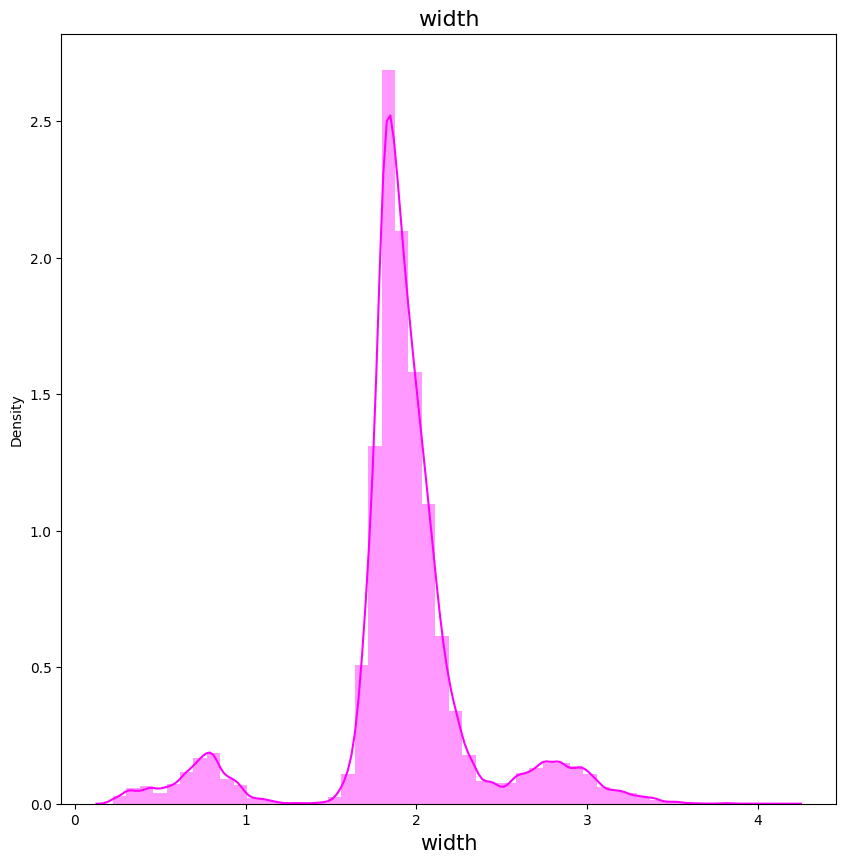

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df_train_objects['width'], color='magenta', ax=ax).set_title('width', fontsize=16)
plt.xlabel('width', fontsize=15)
plt.show()

### 2.2.6 Distribution of `length`

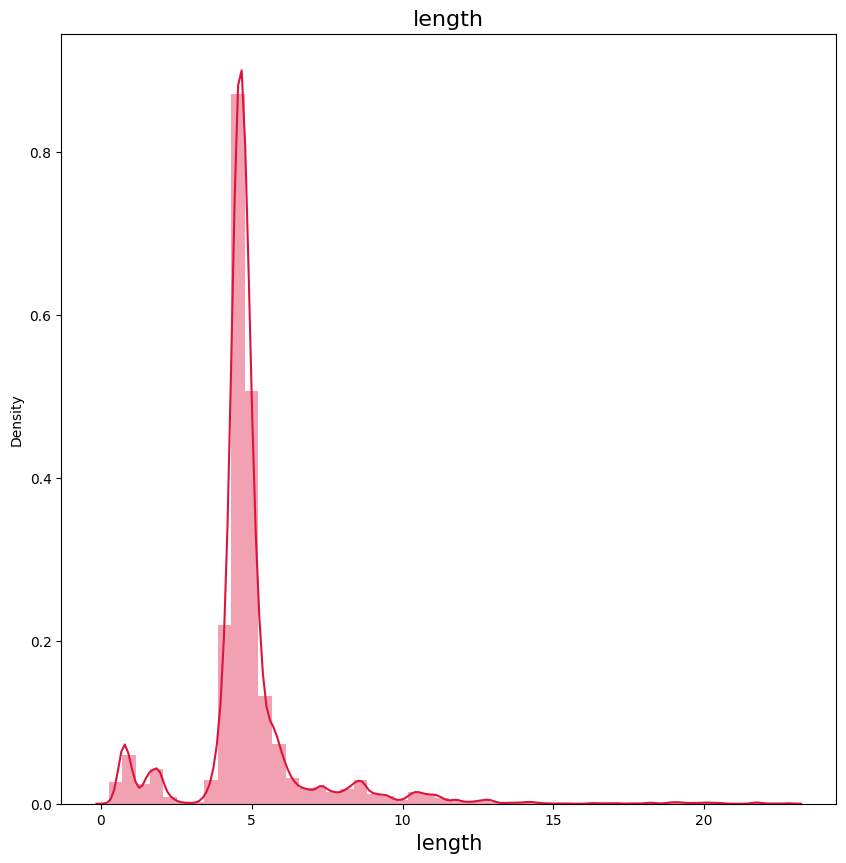

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df_train_objects['length'], color='crimson', ax=ax).set_title('length', fontsize=16)
plt.xlabel('length', fontsize=15)
plt.show()

### 2.2.7 Distribution of `length`

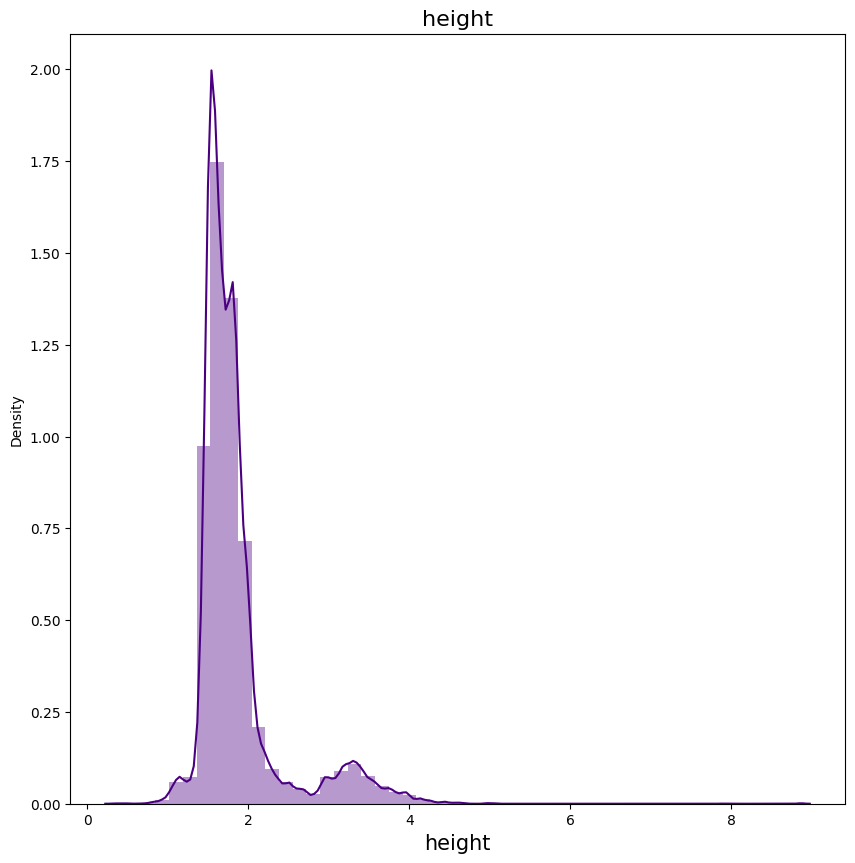

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(df_train_objects['height'], color='indigo', ax=ax).set_title('height', fontsize=16)
plt.xlabel('height', fontsize=15)
plt.show()

### 2.2.8 Frequency of object classes

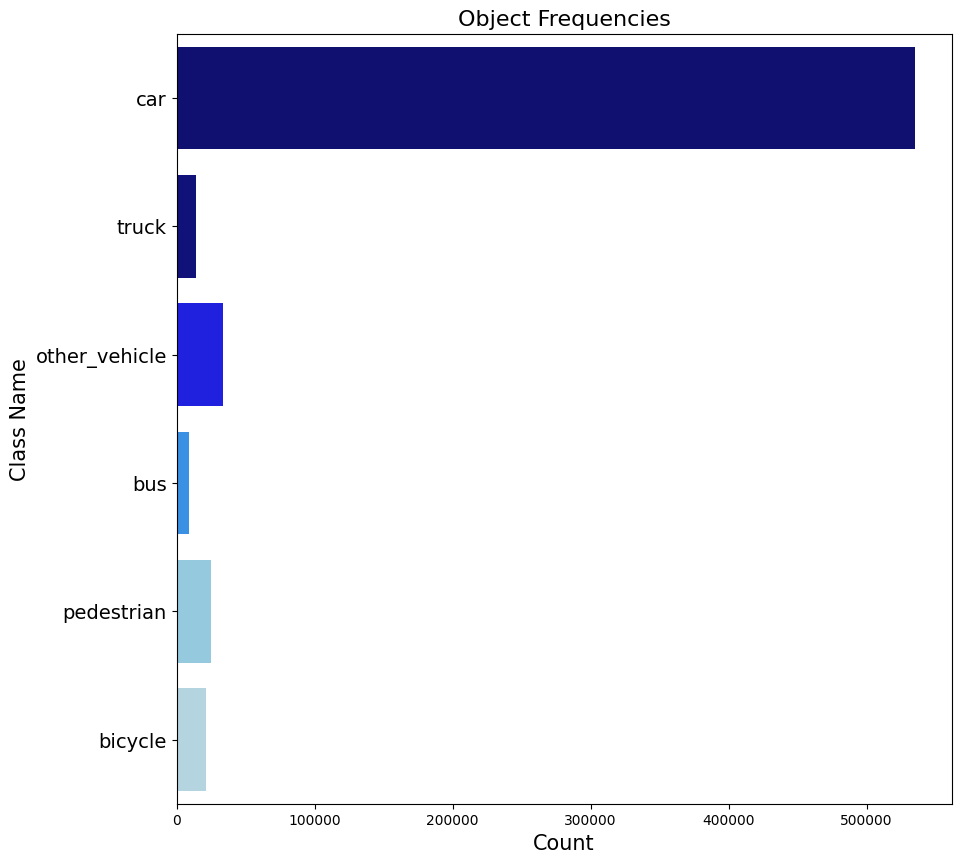

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="class_name", data=df_train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                     palette=['navy', 'darkblue', 'blue', 'dodgerblue', 'skyblue', 'lightblue']).set_title('Object Frequencies', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("Class Name", fontsize=15)
plt.show(plot)

### 2.2.9 `center_x` vs `class_name`

In [49]:
def comparison_plots(df, _x, _y, _query, _palette, _title, type_of_plot="violinplot"):

    fig, ax = plt.subplots(figsize=(15, 15))

    if type_of_plot == "violinplot":
        plot = sns.violinplot(x=_x, y=_y, data=df.query(_query), palette=_palette, split=True, ax=ax).set_title(_title, fontsize=16)
    elif type_of_plot == "boxplot":
        plot = sns.boxplot(x=_x, y=_y, data=df.query(_query), palette=_palette, ax=ax).set_title(_title, fontsize=16)
    else:
        print("Choose: violinplot or boxplot!")
    
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel(_x, fontsize=15)
    plt.ylabel(_y, fontsize=15)
    plt.show(plot)

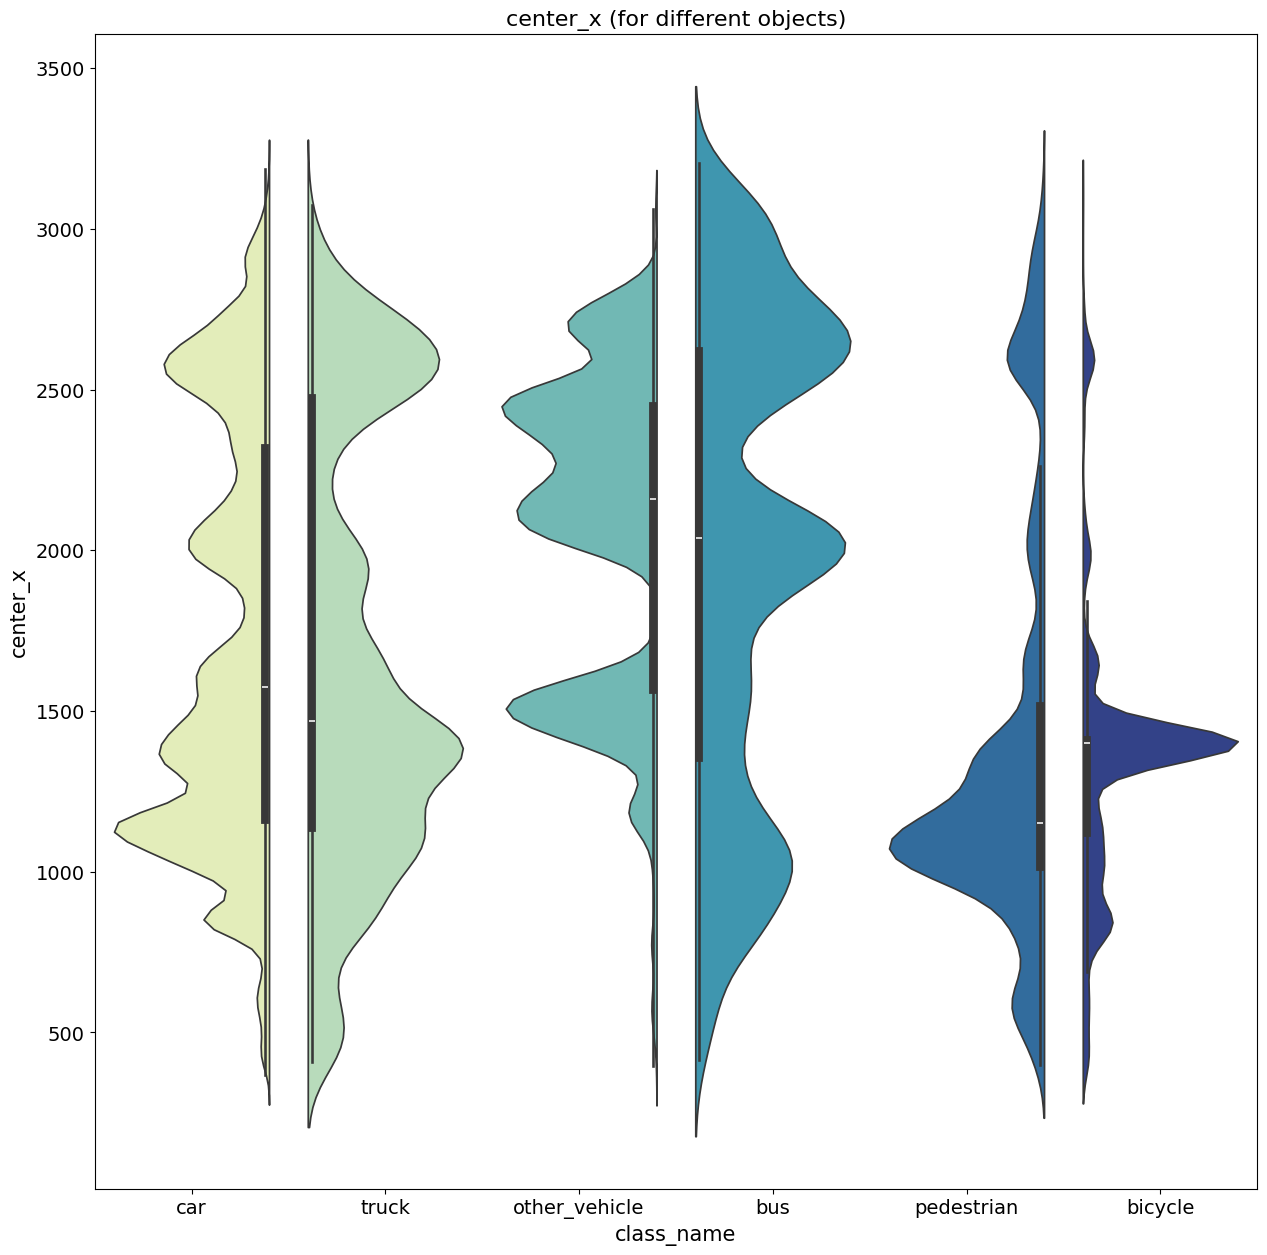

In [50]:
comparison_plots(df_train_objects, _x="class_name", _y="center_x", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='YlGnBu', _title='center_x (for different objects)', 
                 type_of_plot="violinplot")

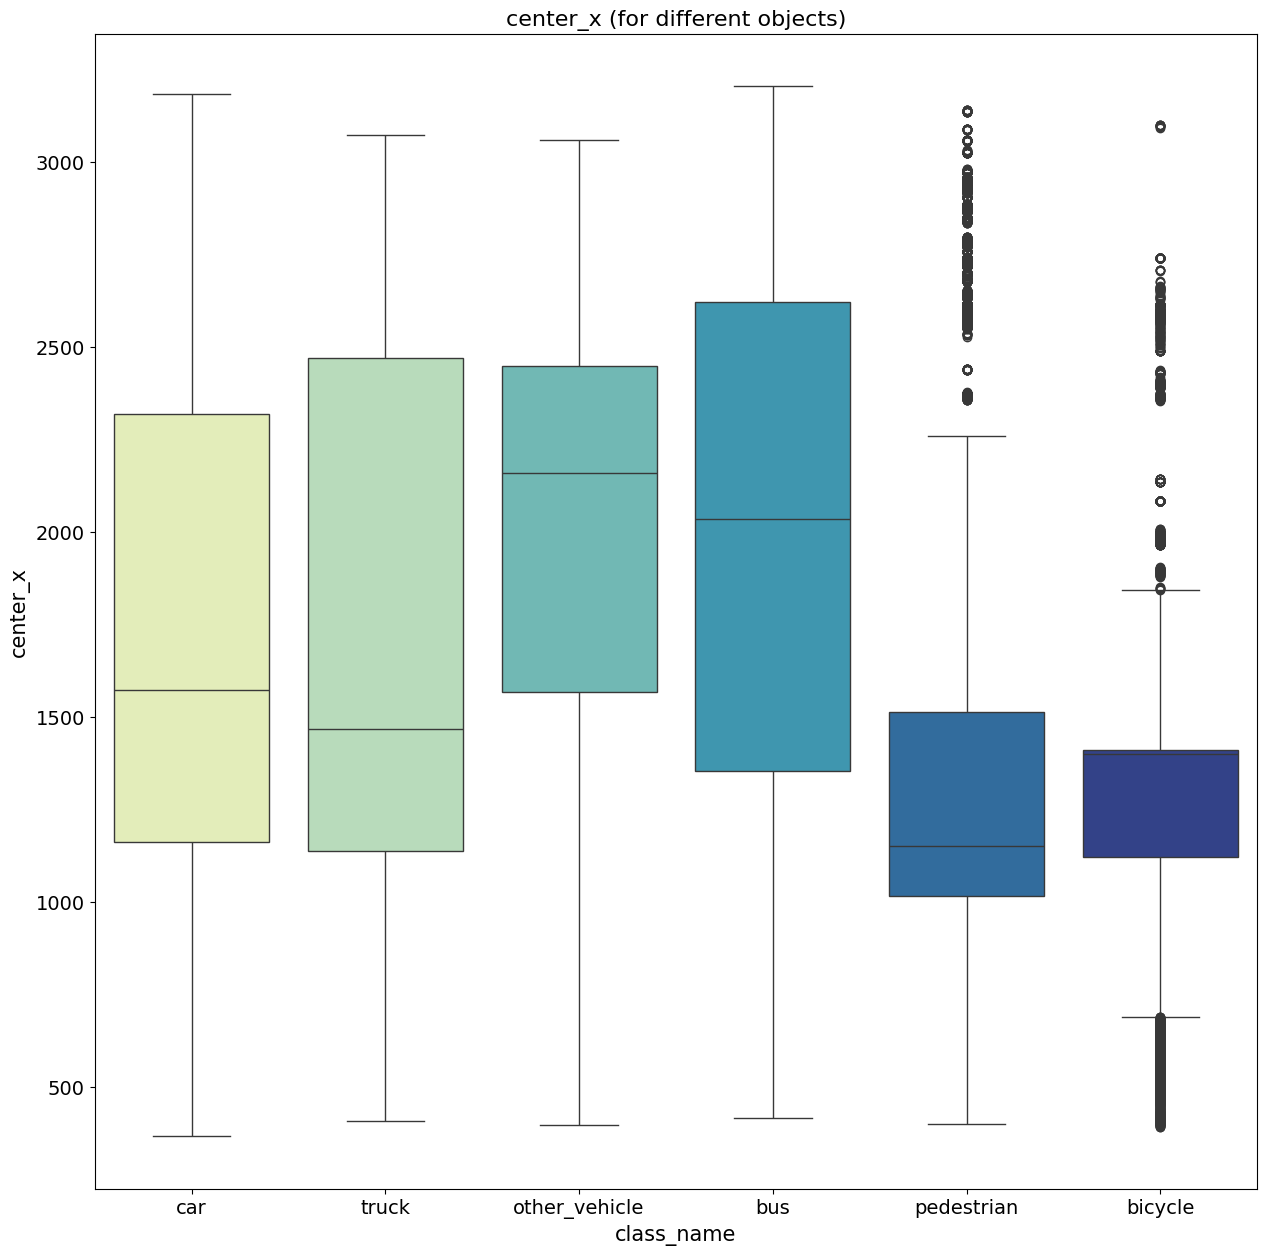

In [51]:
comparison_plots(df_train_objects, _x="class_name", _y="center_x", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='YlGnBu', _title='center_x (for different objects)', 
                 type_of_plot="boxplot")

### 2.2.10 `center_y` vs `class_name`

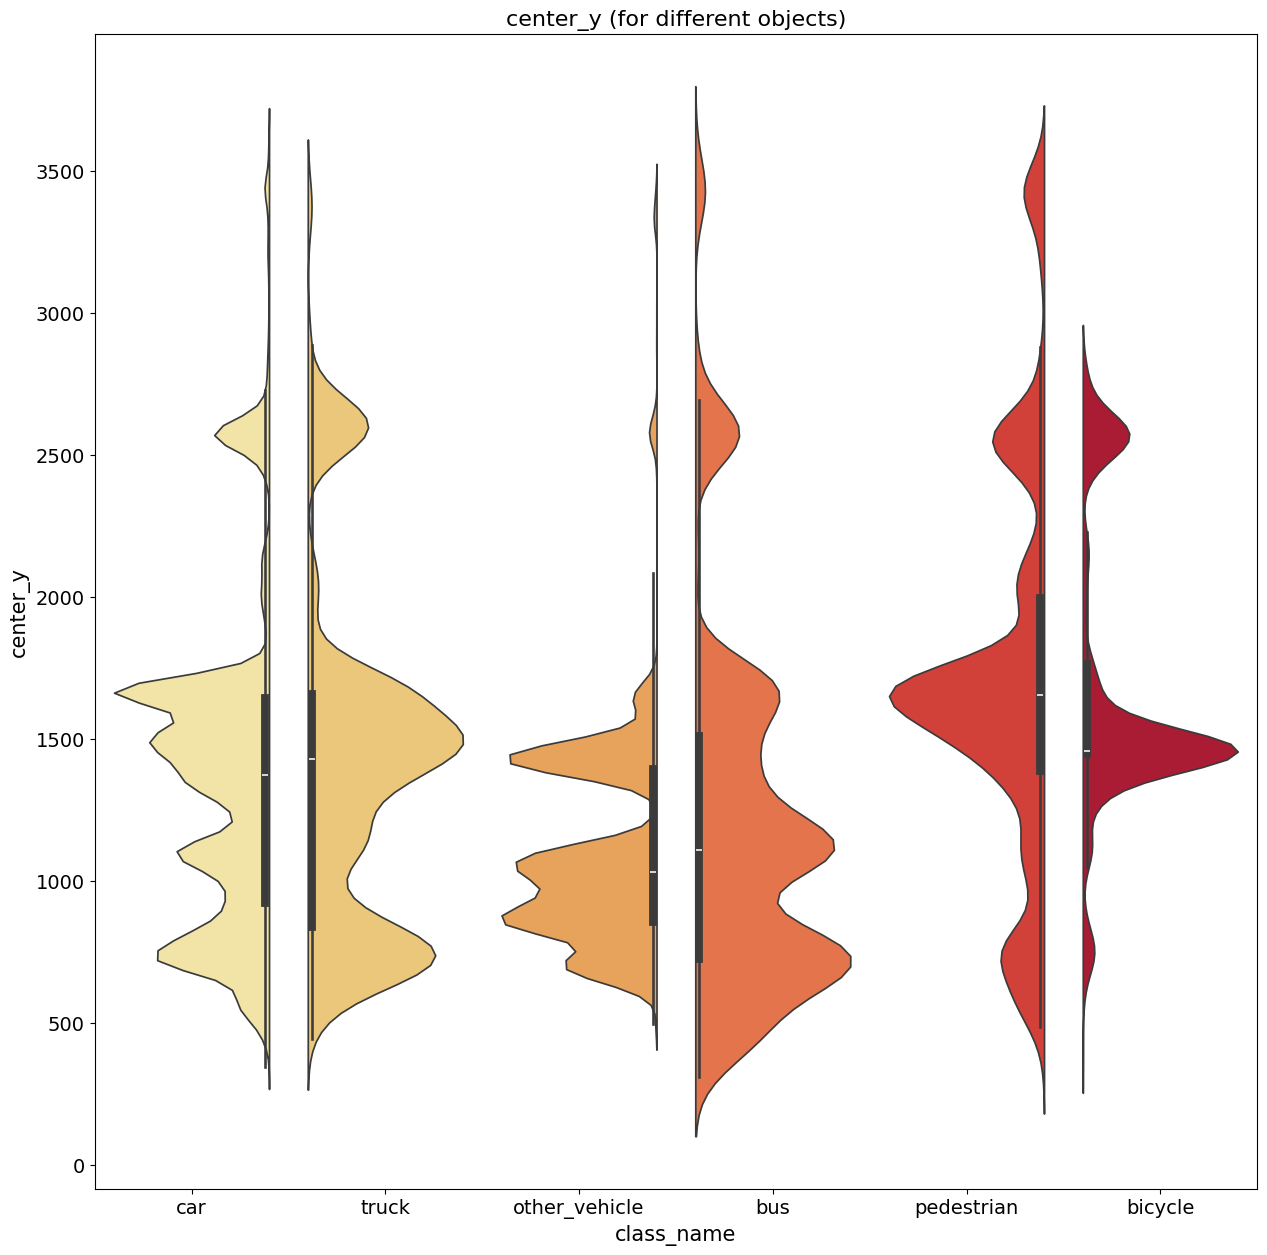

In [52]:
comparison_plots(df_train_objects, _x="class_name", _y="center_y", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='YlOrRd', _title='center_y (for different objects)', 
                 type_of_plot="violinplot")

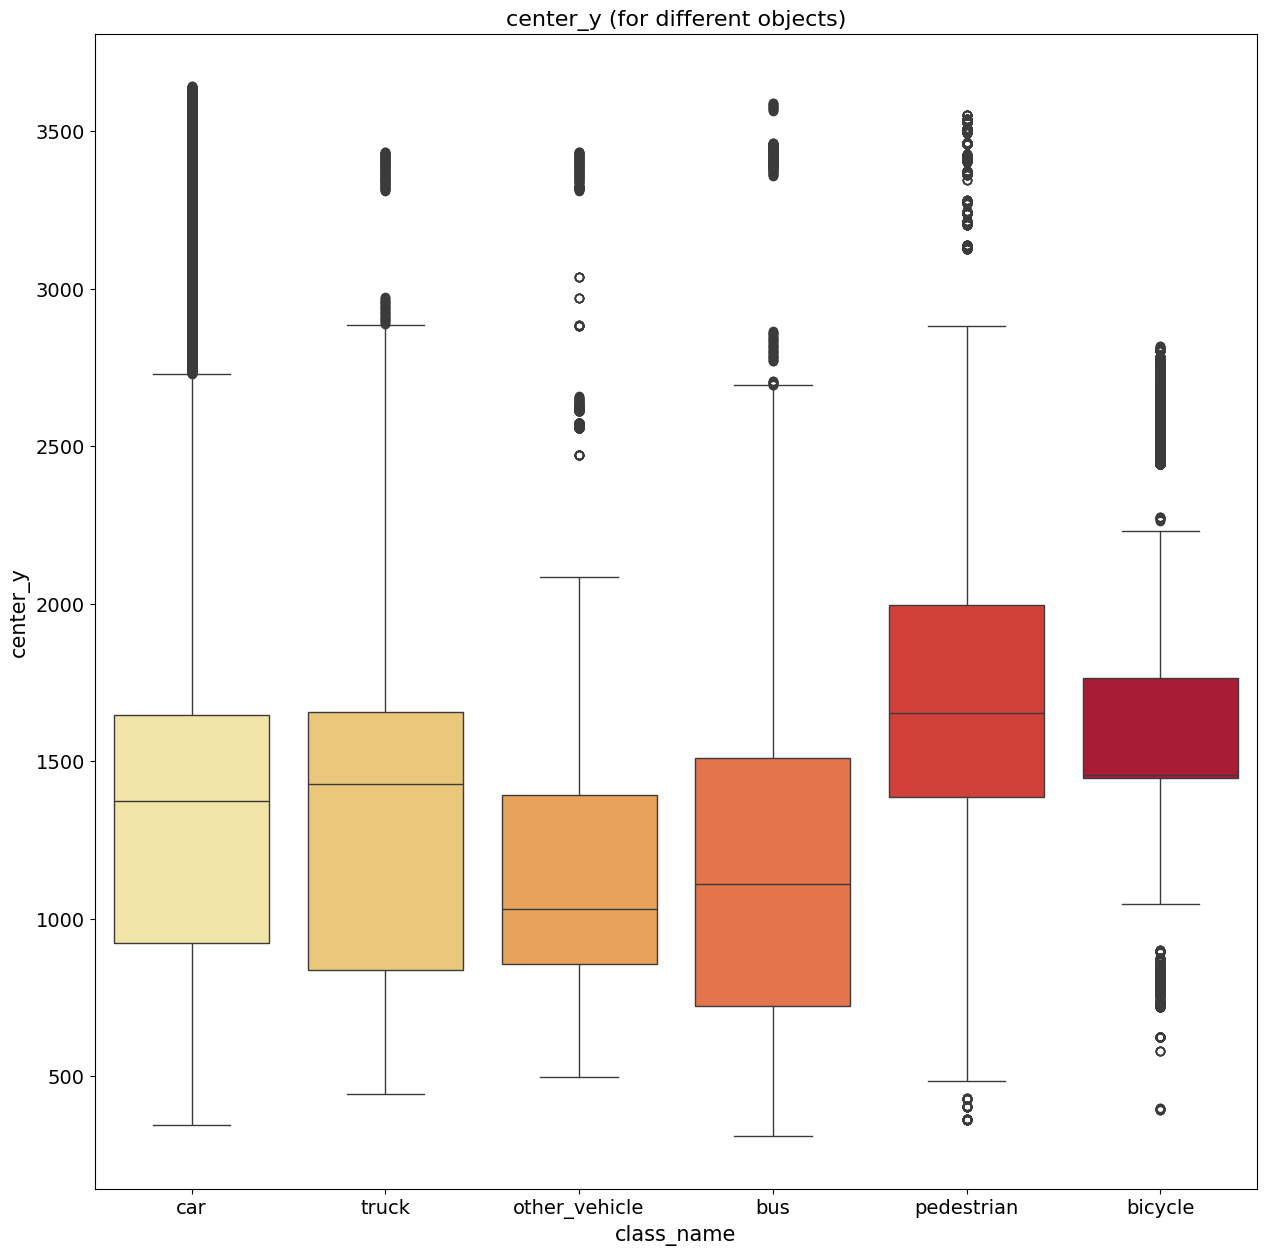

In [53]:
comparison_plots(df_train_objects, _x="class_name", _y="center_y", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='YlOrRd', _title='center_y (for different objects)', 
                 type_of_plot="boxplot")

### 2.2.11 `center_z` vs `class_name`

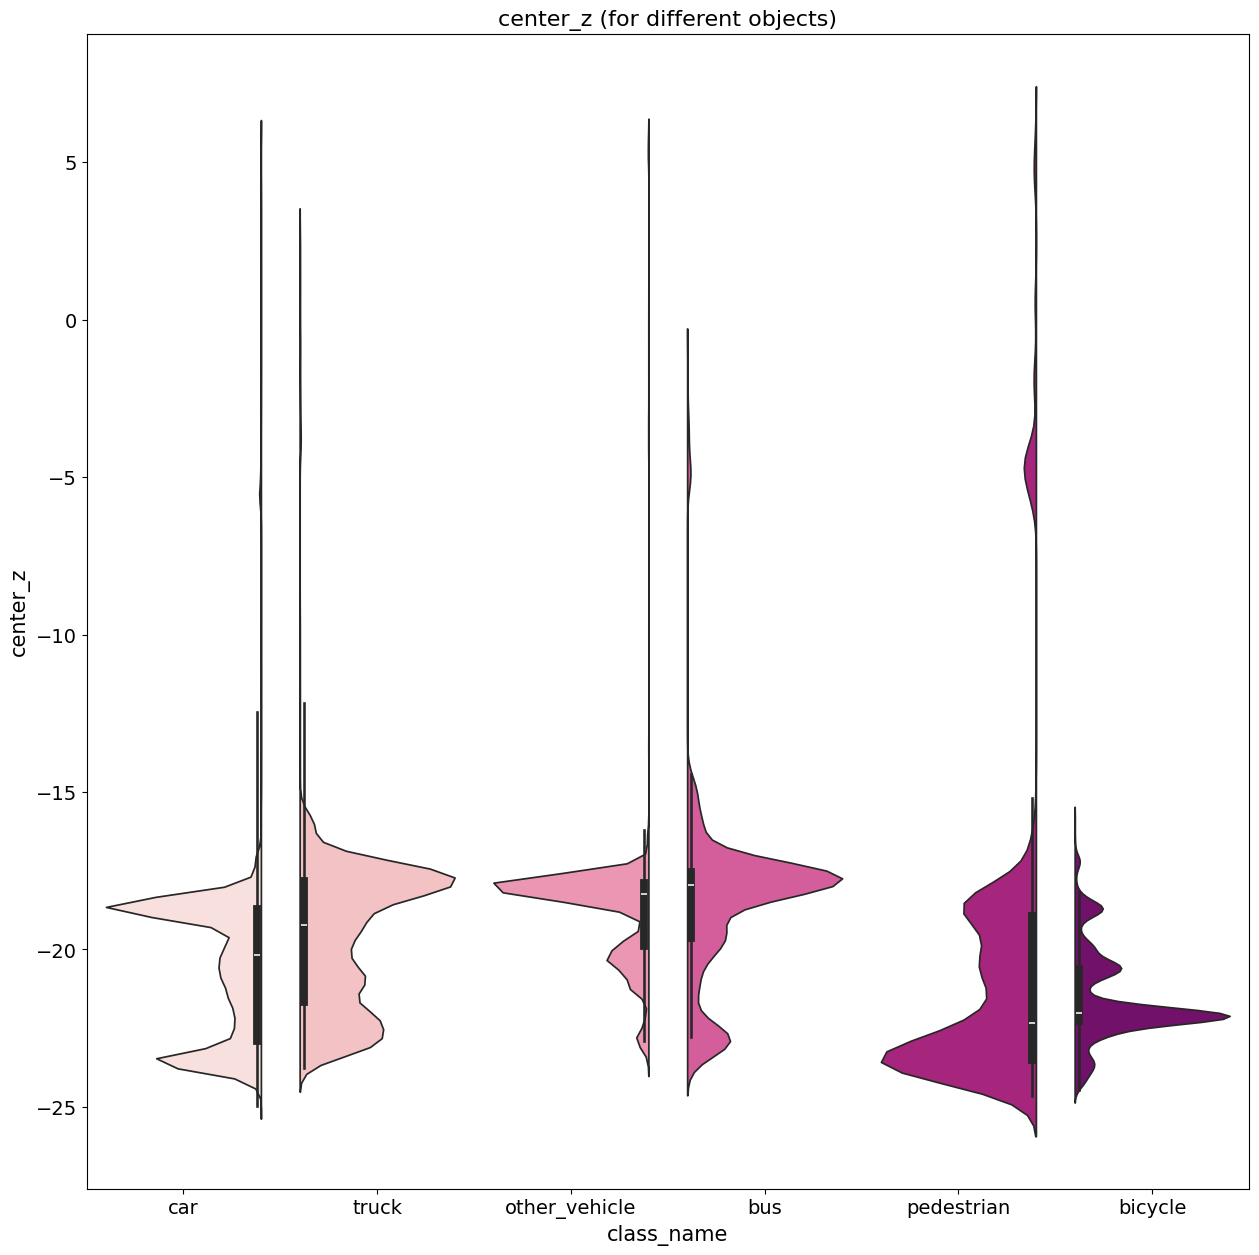

In [54]:
comparison_plots(df_train_objects, _x="class_name", _y="center_z", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='RdPu', _title='center_z (for different objects)', 
                 type_of_plot="violinplot")

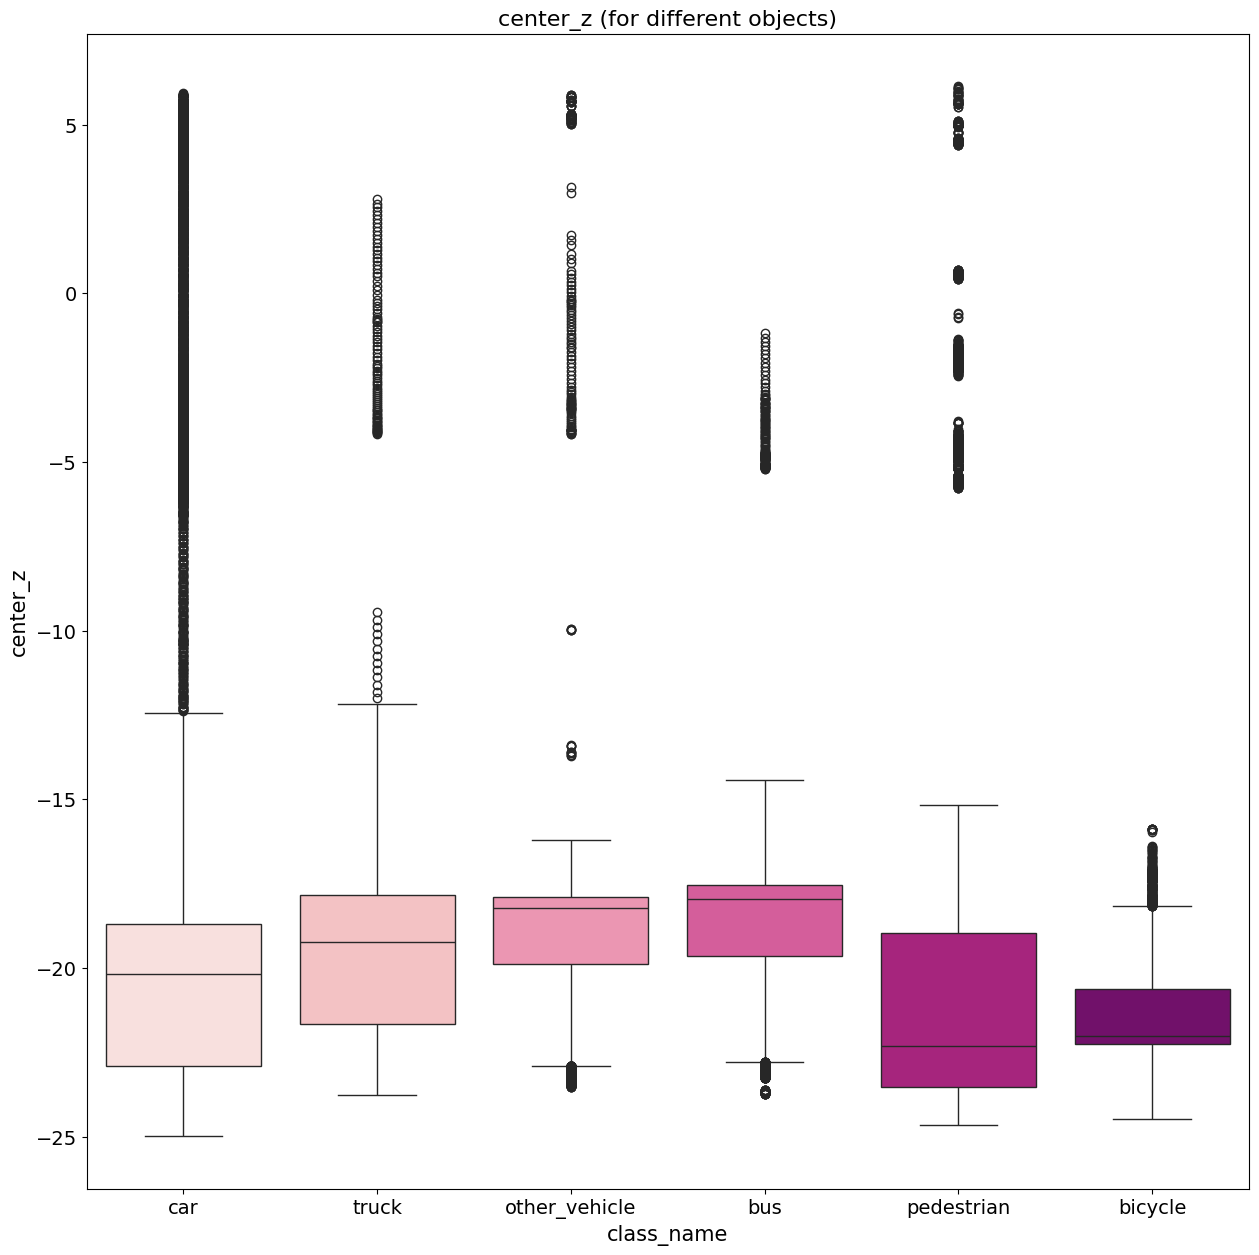

In [55]:
comparison_plots(df_train_objects, _x="class_name", _y="center_z", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='RdPu', _title='center_z (for different objects)', 
                 type_of_plot="boxplot")

### 2.2.12 `wdith` vs `class_name`

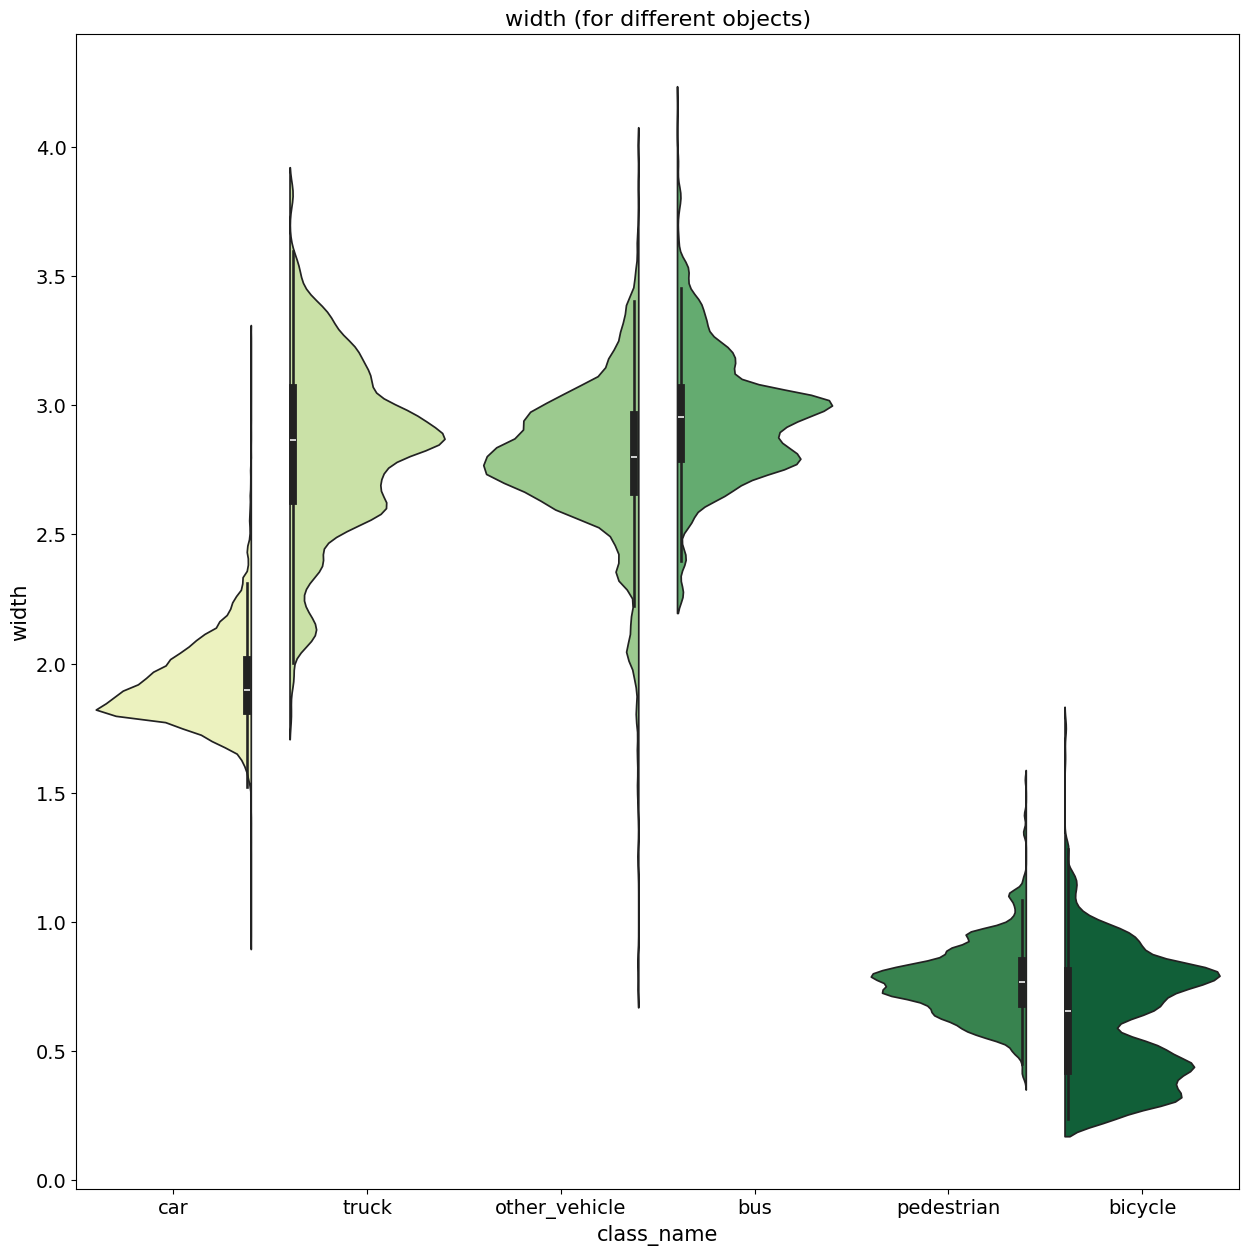

In [56]:
comparison_plots(df_train_objects, _x="class_name", _y="width", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='YlGn', _title='width (for different objects)', 
                 type_of_plot="violinplot")

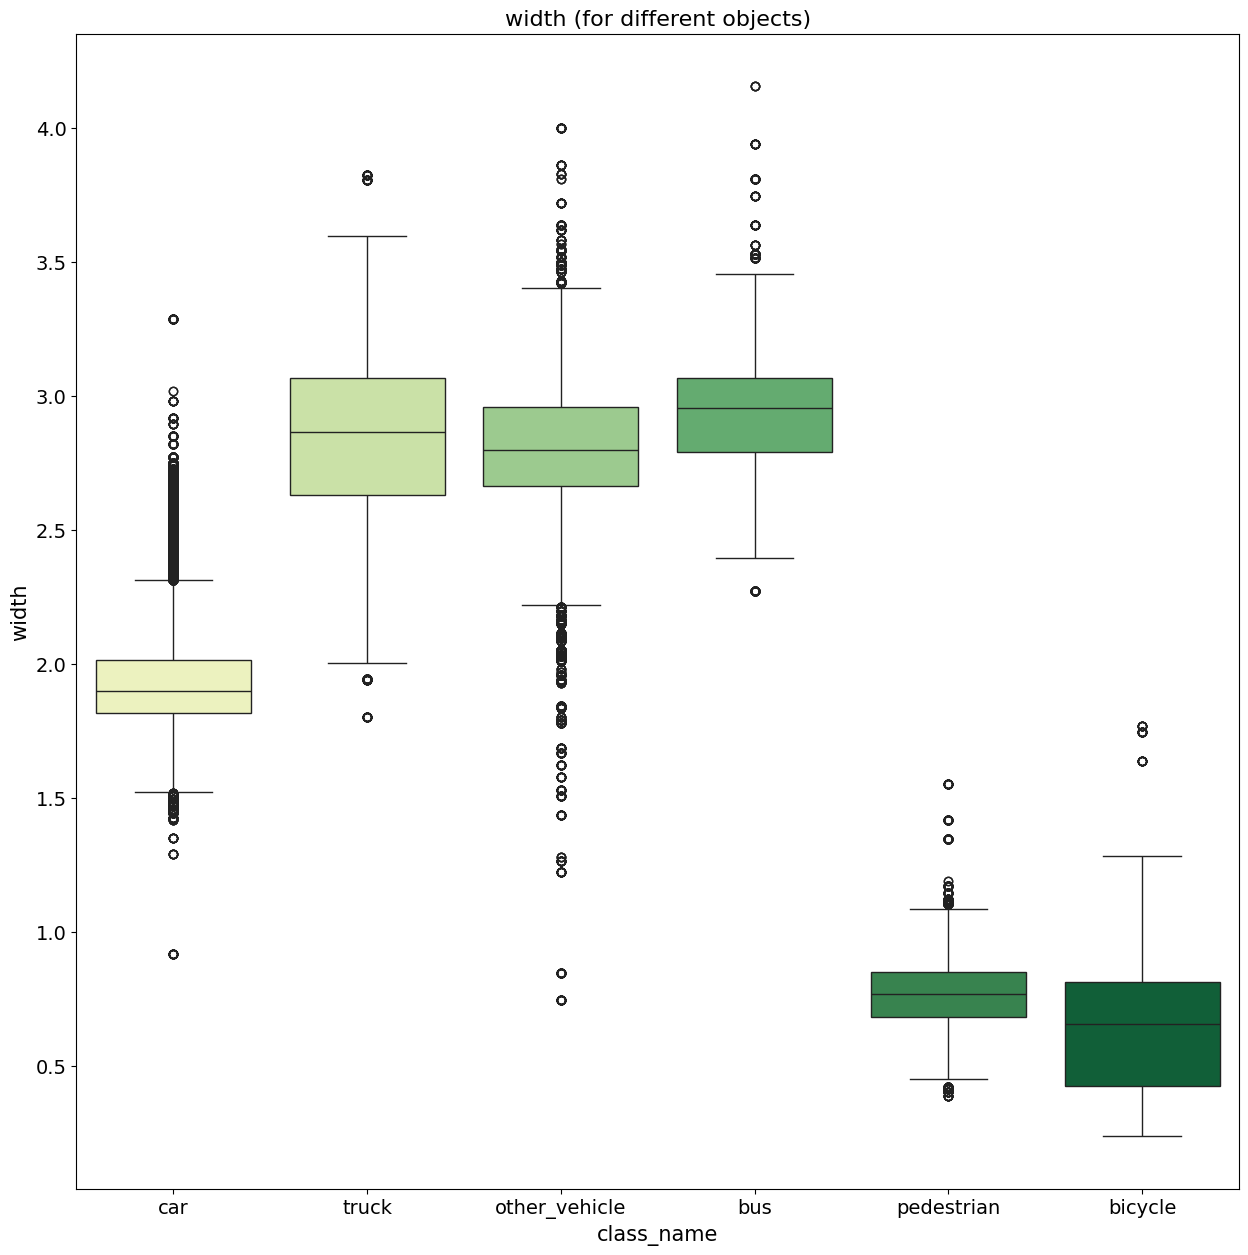

In [57]:
comparison_plots(df_train_objects, _x="class_name", _y="width", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='YlGn', _title='width (for different objects)', 
                 type_of_plot="boxplot")

### 2.2.13 `length` vs `class_name`

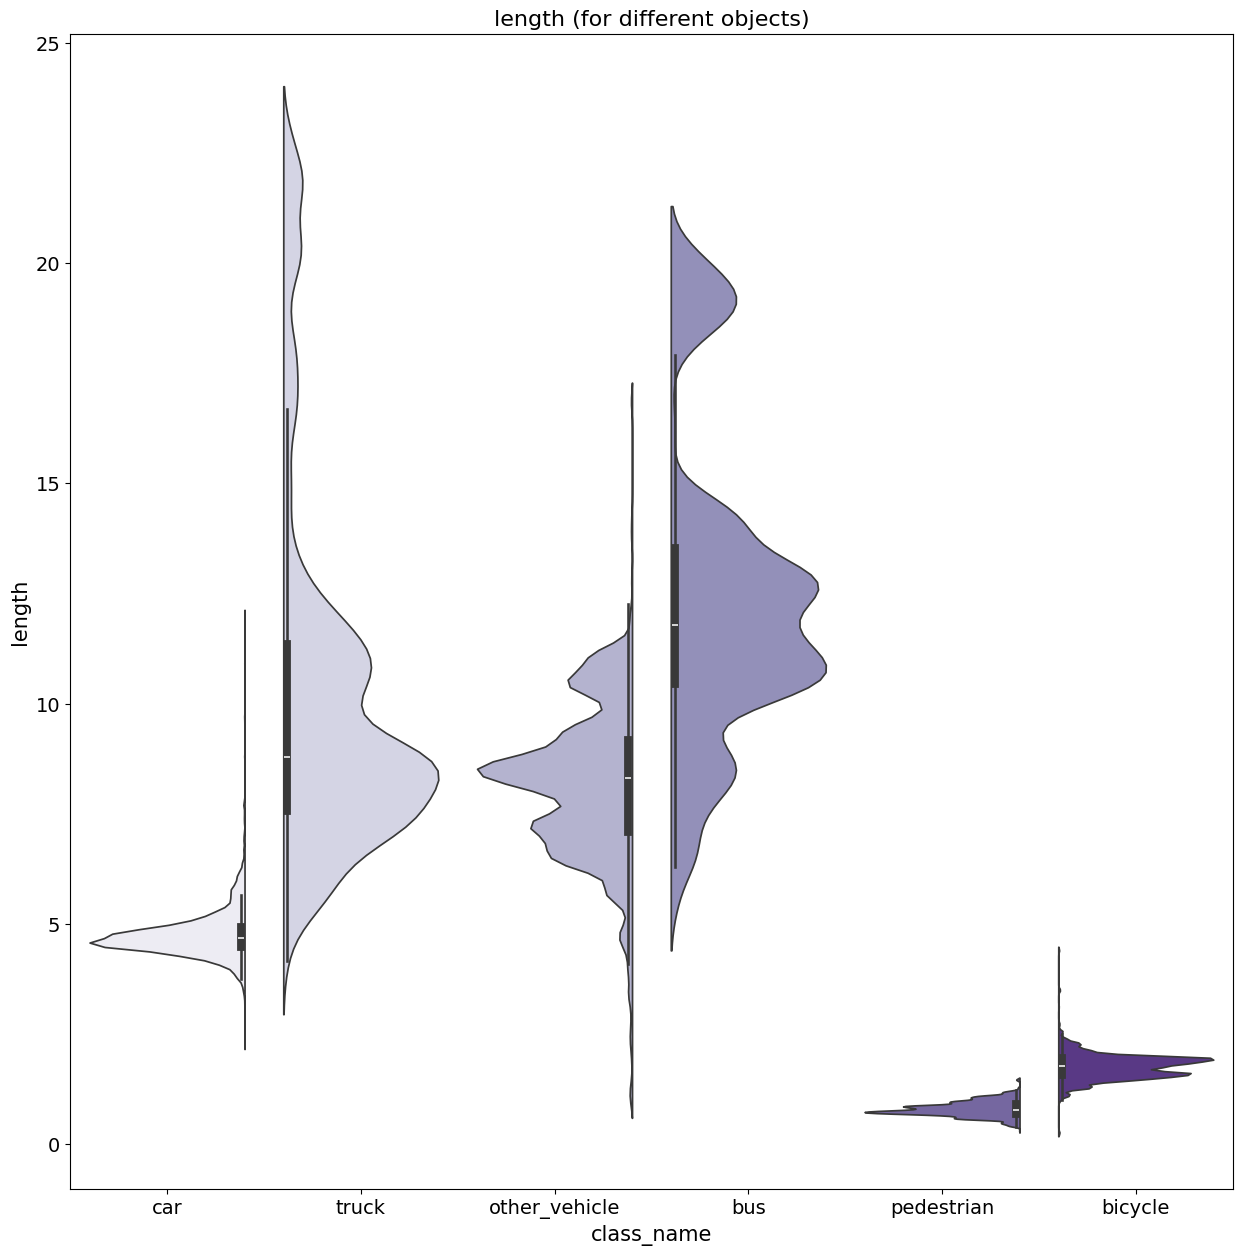

In [58]:
comparison_plots(df_train_objects, _x="class_name", _y="length", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='Purples', _title='length (for different objects)', 
                 type_of_plot="violinplot")

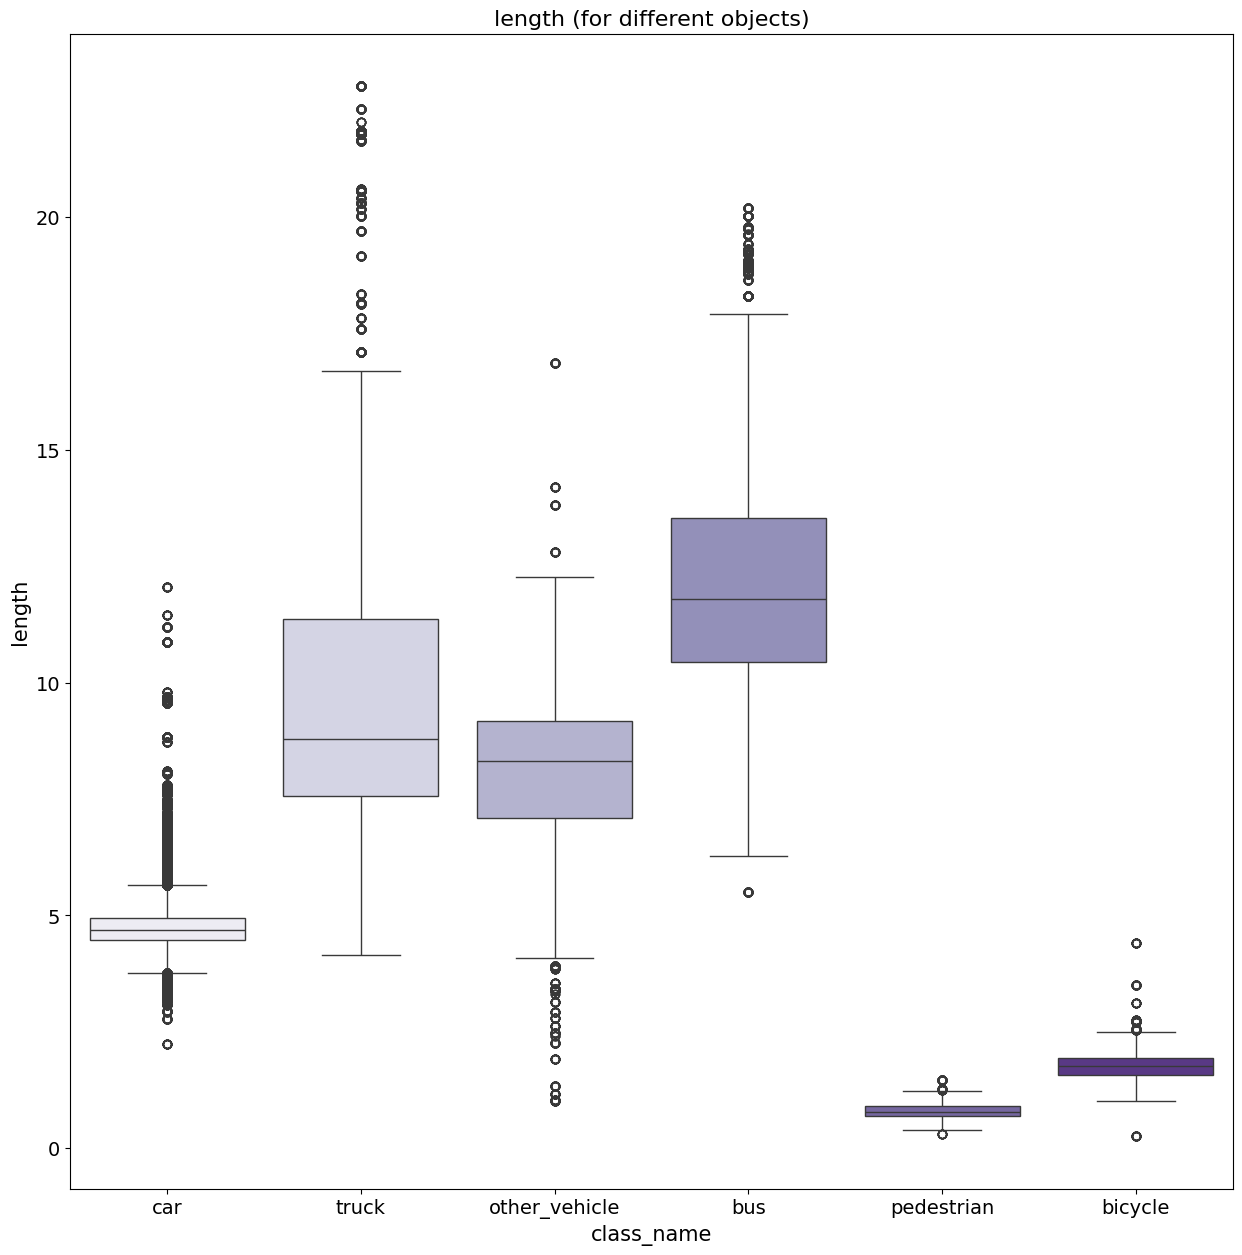

In [59]:
comparison_plots(df_train_objects, _x="class_name", _y="length", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='Purples', _title='length (for different objects)', 
                 type_of_plot="boxplot")

### 2.2.14 `height` vs `class_name`

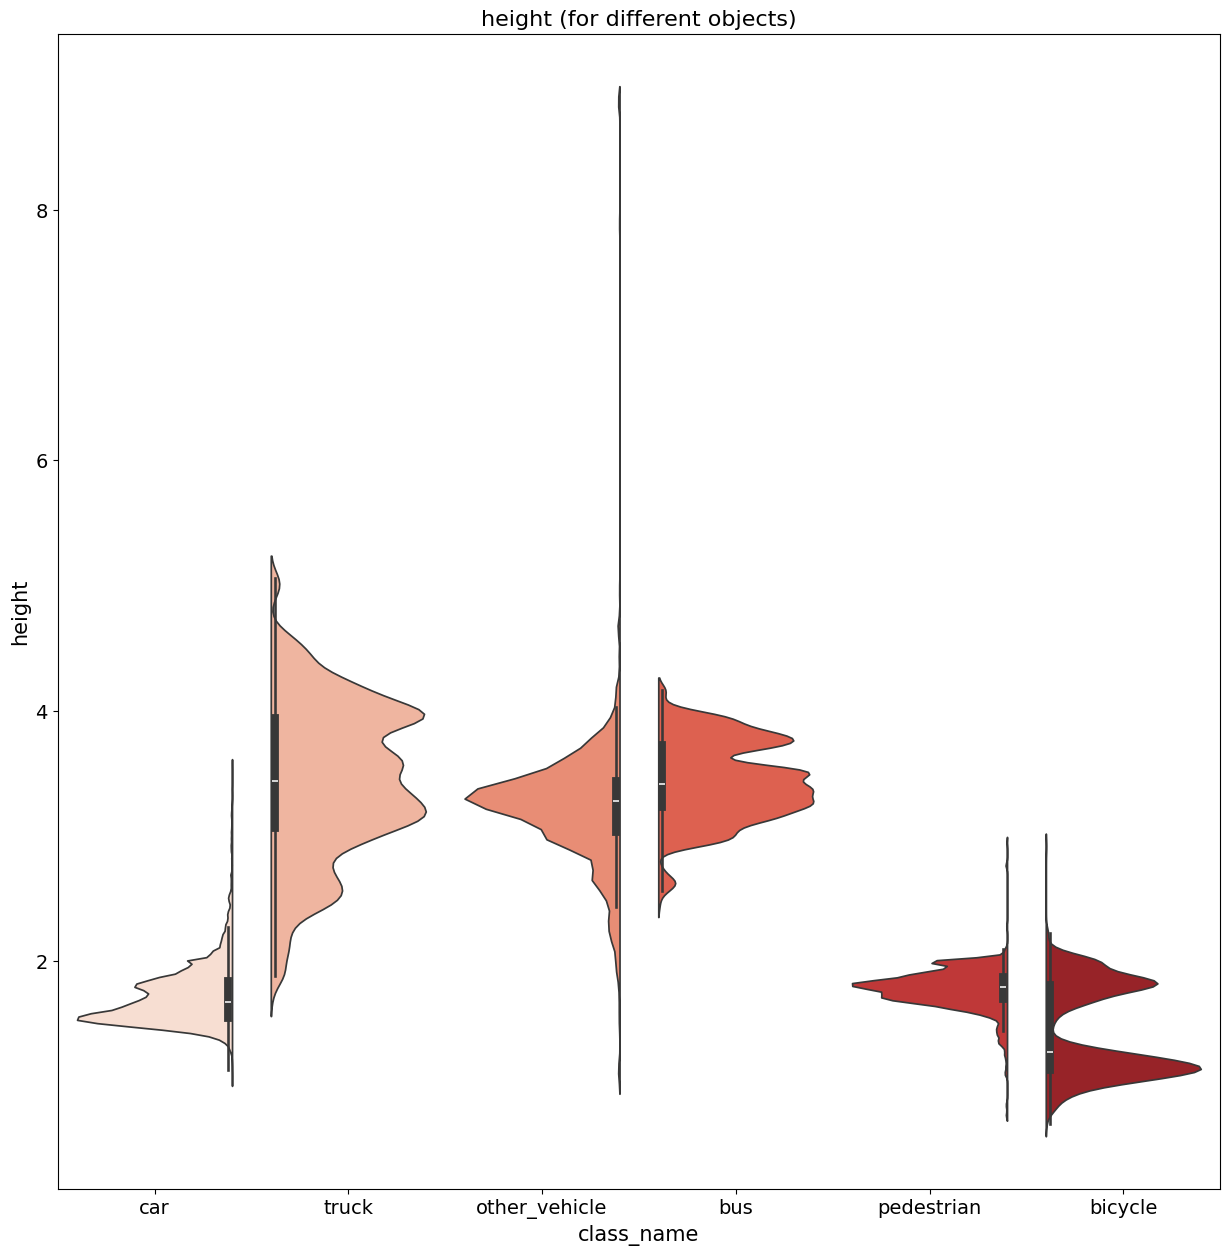

In [60]:
comparison_plots(df_train_objects, _x="class_name", _y="height", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='Reds', _title='height (for different objects)', 
                 type_of_plot="violinplot")

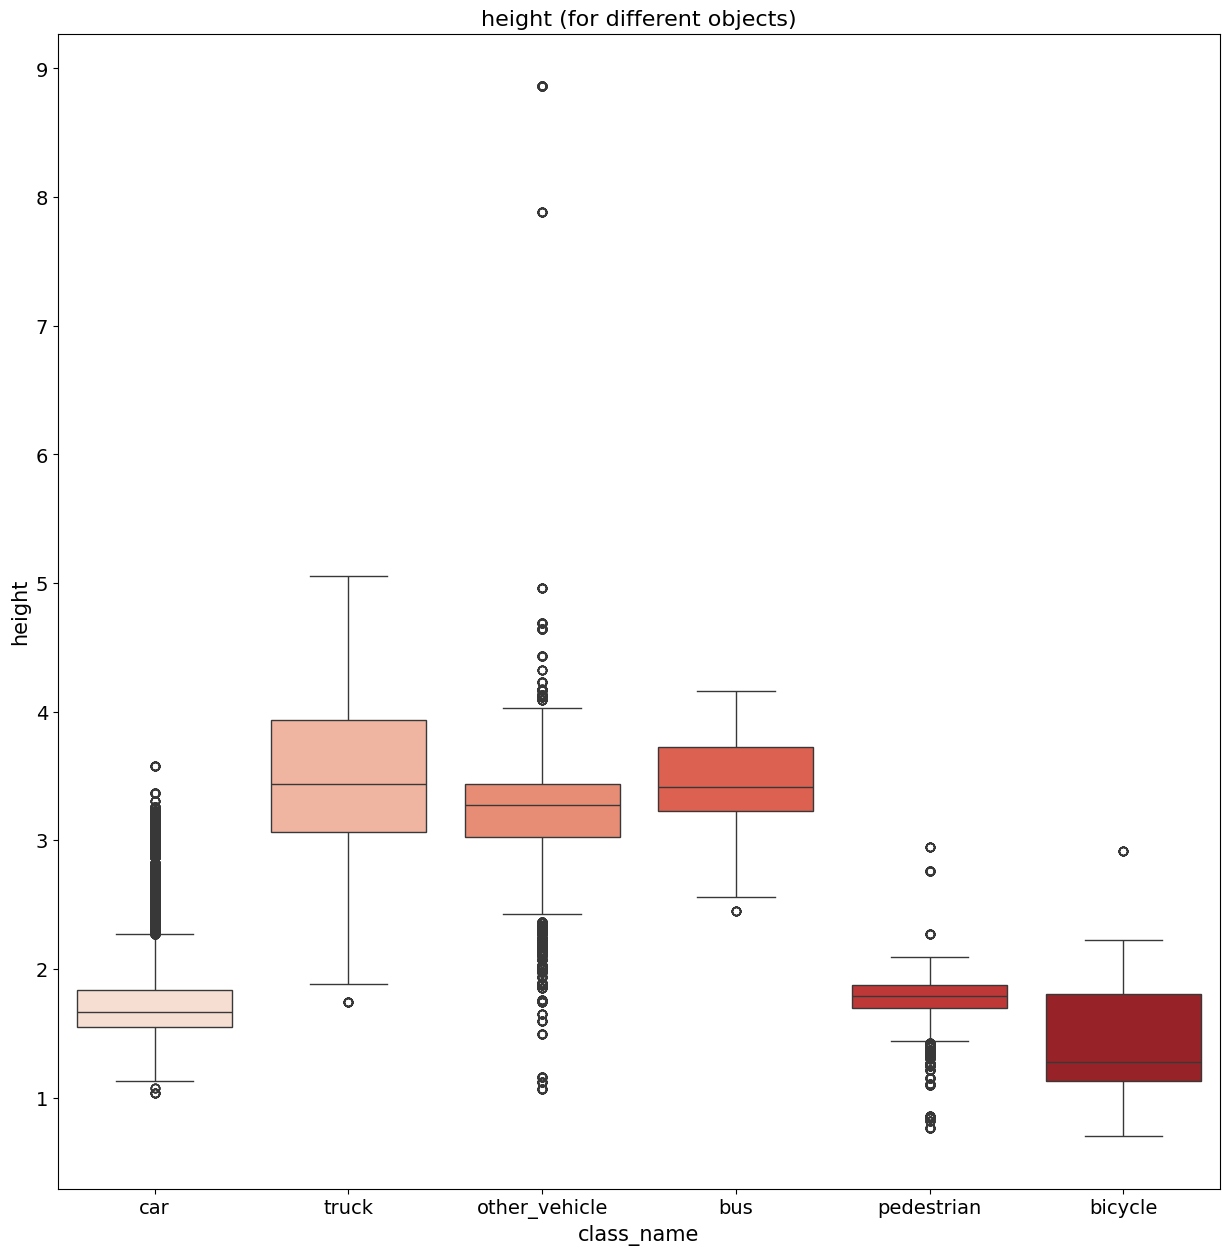

In [61]:
comparison_plots(df_train_objects, _x="class_name", _y="height", 
                 _query='class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"', 
                 _palette='Reds', _title='height (for different objects)', 
                 type_of_plot="boxplot")